In [50]:
from scipy.optimize import fminbound
from pylab import mpl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 图像显示中文
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']


class MyLogisticRegression:
    def __init__(self, max_iter=10000, distance=3, epsilon=1e-6):
        """
        逻辑斯谛回归
        :param max_iter: 最大迭代次数 
        :param distance: 一维搜索的长度范围
        :param epsilon: 迭代停止阈值
        """
        self.max_iter = max_iter
        self.epsilon = epsilon
        # 权重
        self.w = None
        self.distance = distance
        self._X = None
        self._y = None

    @staticmethod
    def preprocessing(X):
        """将原始X末尾加上一列，该列数值全部为1"""
        row = X.shape[0]
        y = np.ones(row).reshape(row, 1)
        return np.hstack((X, y))

    @staticmethod
    def sigmod(x):
        return 1 / (1 + np.exp(-x))

    def grad(self, w):
        z = np.dot(self._X, w.T)
        grad = self._X * (self._y - self.sigmod(z))
        grad = grad.sum(axis=0)
        return grad

    def like_func(self, w):
        z = np.dot(self._X, w.T)
        f = -self._y * z +np.log(1 + np.exp(z))
        return np.sum(f)

    def fit(self, data_x, data_y):
        self._X = self.preprocessing(data_x)
        self._y = data_y.T
        # （1）取初始化w
        w = np.array([[0] * self._X.shape[1]], dtype=np.float64)
        k = 0
        # （2）计算f(w)
        fw = self.like_func(w)
        for _ in range(self.max_iter):
            # 计算梯度g(w)
            grad = self.grad(w)
            # （3）当梯度g(w)的模长小于精度时，停止迭代
            if (np.linalg.norm(grad, axis=0, keepdims=True) < self.epsilon).all():
                self.w = w
                break
            # 梯度方向的一维函数
            def f(x):
                z = w - np.dot(x, grad)
                return self.like_func(z)
            # （3）进行一维搜索，找到使得函数最小的lambda
            _lambda = fminbound(f, -self.distance, self.distance)
            # （4）设置w(k+1)
            w1 = w - np.dot(_lambda, grad)
            fw1 = self.like_func(w1)
            # （4）当f(w(k+1))-f(w(k))的二范数小于精度，或w(k+1)-w(k)的二范数小于精度
            if np.linalg.norm(fw1 - fw) < self.epsilon or \
                    (np.linalg.norm((w1 - w), axis=0, keepdims=True) < self.epsilon).all():
                self.w = w1
                break
            # （5） 设置k=k+1
            k += 1
            w, fw = w1, fw1

        self.grad_ = grad
        self.n_iter_ = k
        self.coef_ = self.w[0][:-1]
        self.intercept_ = self.w[0][-1]

    def predict(self, x):
        p = self.sigmod(np.dot(self.preprocessing(x), self.w.T))
        p[np.where(p > 0.5)] = 1
        p[np.where(p < 0.5)] = 0
        return p

    def score(self, X, y):
        y_c = self.predict(X)
        # 计算准确率
        error_rate = np.sum(np.abs(y_c - y.T)) / y_c.shape[0]
        return 1 - error_rate

    def draw(self, X, y):
        # 分隔正负实例点
        y = y[0]
        X_po = X[np.where(y == 1)]
        X_ne = X[np.where(y == 0)]
        # 绘制数据集散点图
        ax = plt.axes(projection='3d')
        x_1 = X_po[0, :]
        y_1 = X_po[1, :]
        z_1 = X_po[2, :]
        x_2 = X_ne[0, :]
        y_2 = X_ne[1, :]
        z_2 = X_ne[2, :]
        ax.scatter(x_1, y_1, z_1, c="r", label="正实例")
        ax.scatter(x_2, y_2, z_2, c="b", label="负实例")
        ax.set_xlabel('X')  # 设置x坐标轴
        ax.set_ylabel('Y')  # 设置y坐标轴
        ax.set_zlabel('Z')  # 设置z坐标轴
        ax.set_xlim(-2,4)
        ax.set_ylim(-2,4)
        ax.set_zlim(-2,4)
        ax.legend(loc='best')
        # 绘制透明度为0.5的分隔超平面
        x = np.linspace(-3, 3, 3)
        y = np.linspace(-3, 3, 3)
        x_3, y_3 = np.meshgrid(x, y)
        a, b, c, d = self.w[0]
        z_3 = -(a * x_3 + b * y_3 + d) / c
        # 调节透明度
        ax.plot_surface(x_3, y_3, z_3, alpha=0.5)
        plt.show()

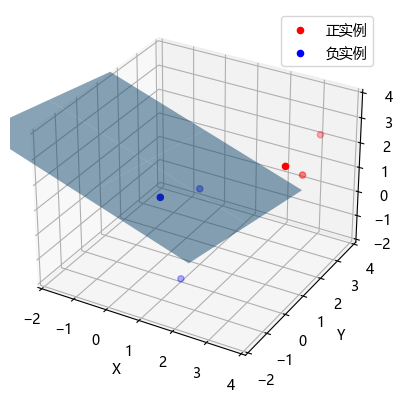

迭代次数：2095次
梯度：[ 7.33881397e-05  2.44073067e-05  2.52604176e-04 -5.13424350e-04]
权重：[  4.34496173   2.05340452   9.64074166 -22.85079478]
模型准确率：100.00%


In [51]:
# 训练数据集
X_train = np.array([[3, 3, 3], [4, 3, 2], [2, 1, 2], [1, 1, 1], [-1, 0, 1], [2, -2, 1]])
y_train = np.array([[1, 1, 1, 0, 0, 0]])
# 构建实例，进行训练
clf = MyLogisticRegression(epsilon=1e-6)
clf.fit(X_train, y_train)
clf.draw(X_train, y_train)
print("迭代次数：{}次".format(clf.n_iter_))
print("梯度：{}".format(clf.grad_))
print("权重：{}".format(clf.w[0]))
print("模型准确率：%0.2f%%" % (clf.score(X_train, y_train) * 100))
